# Data Mining - Homework 4
## Mohammad Bahrami - 9724133
### Question 2

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#### Preprocessing

In [4]:
dataset = pd.read_csv('Wholesale customers data.csv')
dataset.isna().sum()

Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64

There are no `Nan` Values in the dataset.

In [5]:
numeric_columns = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']
dataset.loc[:, numeric_columns] = dataset.loc[:, numeric_columns].apply(
    lambda z: (z - z.mean()) / z.std()
)

In [6]:
dataset = dataset.drop(
    index=dataset.loc[((dataset.loc[:, numeric_columns] > 3) | (dataset.loc[:, numeric_columns] < -3)).any(axis=1)].index
).reset_index(drop=True)

In [7]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2).fit(dataset)
pca_df = pd.DataFrame(pca.transform(dataset))

#### Part a

In [25]:
from sklearn.cluster import AgglomerativeClustering
ward_clusterer = AgglomerativeClustering(n_clusters=None, linkage='ward', distance_threshold=0).fit(pca_df)

In [27]:
counts = np.zeros(ward_clusterer.children_.shape[0])
n_samples = pca_df.shape[0]
for i, merge in enumerate(ward_clusterer.children_):
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            current_count += 1  # leaf node
        else:
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

linkage_matrix = np.column_stack(
    [ward_clusterer.children_, ward_clusterer.distances_, counts]
).astype(float)
#Code Source: Sklearn Documention Examples

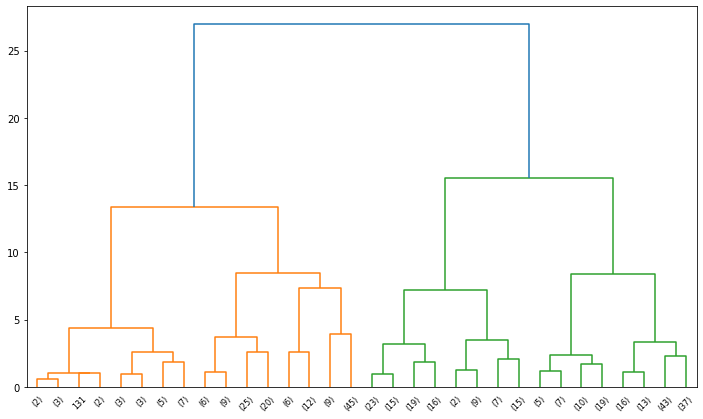

In [58]:
from scipy.cluster.hierarchy import dendrogram
fig, ax = plt.subplots()
dendrogram(
    linkage_matrix,
    truncate_mode='level',
    p=4,
)
fig.set_size_inches((12, 7))

#### Part b

In [61]:
from sklearn.metrics import silhouette_score
k_range = np.arange(2, 11)
silh_list = []
for k in k_range:
    clusterer = AgglomerativeClustering(n_clusters=k, linkage='ward').fit(pca_df)
    silh_list.append(
        silhouette_score(
            pca_df,
            clusterer.labels_,
            metric='euclidean'
        )
    )

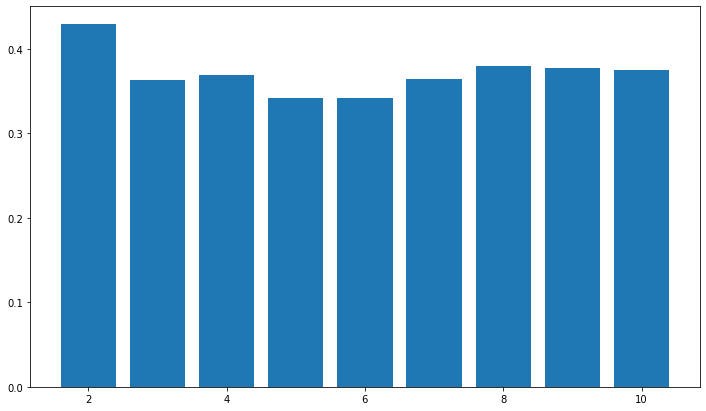

In [63]:
fig, ax = plt.subplots()
ax.bar(
    k_range,
    silh_list
)
fig.set_size_inches((12, 7))

In [69]:
optimum_k = np.argmax(silh_list) + k_range[0]
print(f'Highest Silhouette Score: {np.max(silh_list):.4f} at K: {optimum_k}')

Highest Silhouette Score: 0.4289 at K: 2


#### Part c

In [71]:
best_clusterer = AgglomerativeClustering(n_clusters=optimum_k, linkage='ward').fit(pca_df)
clusters = best_clusterer.labels_

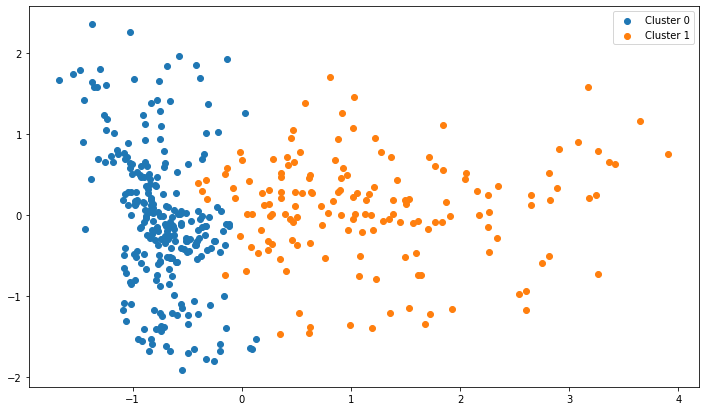

In [72]:
fig, ax = plt.subplots()
for c in range(optimum_k):
    condition = clusters==c
    ax.scatter(
        pca_df.loc[condition, 0],
        pca_df.loc[condition, 1],
        label=f'Cluster {c}'
    )
ax.legend()
fig.set_size_inches((12, 7))

In [73]:
for c in range(optimum_k):
    condition = clusters==c
    print(f'------------------ Cluster {c} ------------------')
    print(pca_df.loc[condition, :].describe())

------------------ Cluster 0 ------------------
                0           1
count  256.000000  256.000000
mean    -0.733874   -0.047985
std      0.317946    0.876295
min     -1.670254   -1.902395
25%     -0.923636   -0.512869
50%     -0.750566   -0.114381
75%     -0.543692    0.473950
max      0.134866    2.360701
------------------ Cluster 1 ------------------
                0           1
count  158.000000  158.000000
mean     1.189062    0.077748
std      0.971150    0.634921
min     -0.396613   -1.459875
25%      0.444122   -0.244094
50%      1.021855    0.165598
75%      1.722159    0.470324
max      3.905879    1.707066


The count of members in each cluster has increased because we had four clusters in the previous part but here we have only two clusters. The variance of each cluster has increased as well because each cluster is containing a larger range of the data.